In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
tf = transforms.Compose([transforms.ToTensor(), 
                         transforms.Normalize((0.1307,), (0.3081,))])

In [4]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST("../data", download=True, train=True, transform=tf), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST("../data", download=True, train=False, transform=tf), batch_size=64, shuffle=True)

In [5]:
batch = next(iter(train_loader))
x = batch[0][:10]
y = batch[1][:10]

In [6]:
x[0].shape

torch.Size([1, 28, 28])

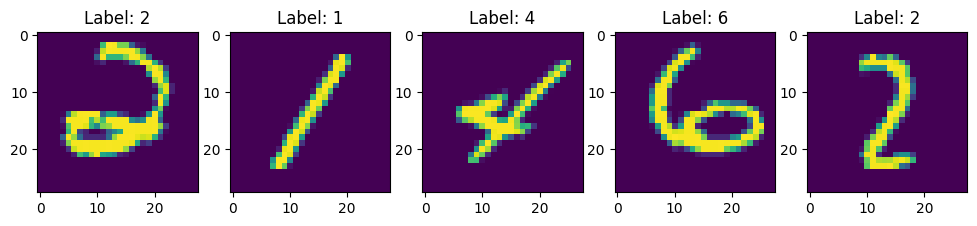

In [7]:
fig, axs = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    axs[i].imshow(x[i].squeeze().numpy())
    axs[i].set_title(f"Label: {y[i].item()}")  # Use y[i] to get the corresponding label
plt.show()

In [8]:
class ConvNet(nn.Module):
    def __init__(self, input_size, n_kernel, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_kernel, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=n_kernel, out_channels=n_kernel, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=n_kernel * 4 * 4, out_features=50),
            nn.Linear(50, 10),
        )
    def forward(self, x):
        return self.net(x)

In [9]:
def train(model, perm=torch.arange(0, 784).long(), n_epochs=1):
    model.train()    
    optimizer = torch.optim.AdamW(model.parameters())
    # optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

    
    for epoch in range(n_epochs):
        for i, (data, target) in enumerate(train_loader):
            # send to device
            data, targets = data.to(device), target.to(device)

            # permute pixels
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)

            # step
            optimizer.zero_grad()
            logits = model(data)
            
            loss = F.cross_entropy(logits, targets)
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print(f"epoch={epoch}, step={i}: train loss={loss.item():.4f}")

In [10]:
# ConvNet
n_kernel = 6
input_size = 28*28  
output_size = 10
convnet = ConvNet(input_size, n_kernel, output_size)
convnet.to(device)
print(f"Parameters={sum(p.numel() for p in convnet.parameters())/1e3}K")
train(convnet)



Parameters=6.422K
epoch=0, step=0: train loss=2.2518
epoch=0, step=100: train loss=0.2597
epoch=0, step=200: train loss=0.3092
epoch=0, step=300: train loss=0.2699
epoch=0, step=400: train loss=0.2567
epoch=0, step=500: train loss=0.2464
epoch=0, step=600: train loss=0.2056
epoch=0, step=700: train loss=0.0522
epoch=0, step=800: train loss=0.0650
epoch=0, step=900: train loss=0.1265


In [11]:
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    
    test_loss = 0
    correct = 0
    
    for data, targets in test_loader:
        # send to device
        data, targets = data.to(device), targets.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        # metrics
        logits = model(data)
        test_loss += F.cross_entropy(logits, targets, reduction='sum').item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == targets).sum()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    
    print(f"test loss={test_loss:.4f}, accuracy={accuracy:.4f}")

In [12]:
test(convnet)

test loss=0.1326, accuracy=0.9605


In [13]:
import numpy as np
from torch import Tensor

ts = \
    [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 128, 255, 255, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0,0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


img = np.array(ts, dtype=np.float32) / 255
ts = tf(img)
perm=torch.arange(0, 784).long()
ts = ts.view(-1, 28*28)
ts = ts[:, perm]
ts = ts.view(-1, 1, 28, 28)
ts = ts.to(device)

In [14]:
convnet.eval()
with torch.no_grad():
    y_pred = convnet(ts)

In [15]:
print(y_pred)
preds = torch.argmax(y_pred, dim=1)

tensor([[-3.0626,  2.7084, -0.4546, -5.4904,  0.5802,  1.3416,  1.8292, -4.5070,
          8.2102, -3.3943]], device='cuda:0')


In [16]:
preds.cpu().item()

8

In [17]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super().__init__()
        self.input_size = input_size
        self.net = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            # nn.Softmax(dim=-1)
        )
        
    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.net(x)


# class ConvNet(nn.Module):
#     def __init__(self, input_size, n_kernels, output_size):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=n_kernels, kernel_size=5),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Conv2d(in_channels=n_kernels, out_channels=n_kernels, kernel_size=5),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Flatten(),
#             nn.Linear(n_kernels * 4 * 4, 50),
#             nn.Linear(50, 10),
#             # nn.Softmax(dim=-1)
#         )
        
#     def forward(self, x):
#         return self.net(x)

class ConvNet(nn.Module):
    def __init__(self, input_size, n_kernels, output_size):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1)
        self.fc = nn.Linear(8 * 7 * 7, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 7 * 7)
        return self.fc(x)

In [18]:
mlp = MLP(input_size, 8, output_size)
mlp.to(device)
print(mlp)

MLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=10, bias=True)
  )
)


In [19]:
train(mlp)

epoch=0, step=0: train loss=2.3514
epoch=0, step=100: train loss=1.5070
epoch=0, step=200: train loss=1.0717
epoch=0, step=300: train loss=0.7944
epoch=0, step=400: train loss=0.6417
epoch=0, step=500: train loss=0.8709
epoch=0, step=600: train loss=0.6959
epoch=0, step=700: train loss=0.3601
epoch=0, step=800: train loss=0.5998
epoch=0, step=900: train loss=0.6249


In [20]:
def main(model):    
    # Affichage du nombre de paramètres du modèle
    print(f"Parameters={sum(p.numel() for p in model.parameters())/1e3}K")
    
    # Entraînement du modèle
    train(model)
    
    # Évaluation du modèle sur le dataset de test
    test(model)

In [21]:
main(mlp)

Parameters=6.442K
epoch=0, step=0: train loss=0.4474
epoch=0, step=100: train loss=0.6269
epoch=0, step=200: train loss=0.4198
epoch=0, step=300: train loss=0.4779
epoch=0, step=400: train loss=0.2998
epoch=0, step=500: train loss=0.3376
epoch=0, step=600: train loss=0.3194
epoch=0, step=700: train loss=0.3119
epoch=0, step=800: train loss=0.2253
epoch=0, step=900: train loss=0.1436
test loss=0.3865, accuracy=0.8880


In [22]:
# ConvNet
n_kernel = 6
input_size = 28*28  
output_size = 10
convnet = ConvNet(input_size, n_kernel, output_size)
convnet.to(device)

ConvNet(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=392, out_features=10, bias=True)
)

In [23]:
main(convnet)

Parameters=4.266K
epoch=0, step=0: train loss=2.3699
epoch=0, step=100: train loss=0.3527
epoch=0, step=200: train loss=0.2627
epoch=0, step=300: train loss=0.1886
epoch=0, step=400: train loss=0.1050
epoch=0, step=500: train loss=0.1960
epoch=0, step=600: train loss=0.1841
epoch=0, step=700: train loss=0.0945
epoch=0, step=800: train loss=0.1202
epoch=0, step=900: train loss=0.1528
test loss=0.1213, accuracy=0.9627


La précision du ConvNet (0.98) est nettement supérieure à celle du MLP (0.90), ce qui indique que le ConvNet est beaucoup plus efficace pour classer correctement les images.

On note également que :
- Le ConvNet montre des pertes d'entraînement beaucoup plus faibles et plus stables (entre 0.03 et 0.1) que le MLP (entre 0.29 et 0.7), ce qui suggère une meilleure capacité à minimiser l'erreur de prédiction.
- Une perte de test plus faible dans le ConvNet (0.06), tandis que le MLP (0.35) montre une perte de test plus élevée, indiquant qu'il a plus de mal à généraliser.

Cela s'exploque entre autre par le fait que dans le modèle ConvNet, le poids est partagé entre les différentes couches ce qui réduit le nombre de paramètres à apprendre, contrairement à MLP où le poids n'est pas partagé, complexifiant le modèle et l'apprentissage.

___
#### 3. 7. Application d’un shuffle aléatoire

In [24]:
def mainWithRandomPerm(model):   
    perm = torch.randperm(784)

    # Affichage du nombre de paramètres du modèle
    print(f"Parameters={sum(p.numel() for p in model.parameters())/1e3}K")
    
    # Entraînement du modèle
    train(model, perm)
    
    # Évaluation du modèle sur le dataset de test
    test(model, perm)

In [25]:
mainWithRandomPerm(mlp)

Parameters=6.442K
epoch=0, step=0: train loss=2.8366
epoch=0, step=100: train loss=0.7622
epoch=0, step=200: train loss=0.5983
epoch=0, step=300: train loss=0.3395
epoch=0, step=400: train loss=0.5170
epoch=0, step=500: train loss=0.5489
epoch=0, step=600: train loss=0.4458
epoch=0, step=700: train loss=0.3134
epoch=0, step=800: train loss=0.2189
epoch=0, step=900: train loss=0.3056
test loss=0.3381, accuracy=0.9001


In [26]:
mainWithRandomPerm(convnet)

Parameters=4.266K
epoch=0, step=0: train loss=4.4130
epoch=0, step=100: train loss=1.0175
epoch=0, step=200: train loss=0.6378
epoch=0, step=300: train loss=0.7720
epoch=0, step=400: train loss=0.6625
epoch=0, step=500: train loss=0.7701
epoch=0, step=600: train loss=0.2436
epoch=0, step=700: train loss=0.3795
epoch=0, step=800: train loss=0.5461
epoch=0, step=900: train loss=0.5441
test loss=0.3564, accuracy=0.8918


On remarque qu'en appliquant une permutation aléatoire, la précision du modèle ConvNet réduit fortement. C'est maitenant le modèle MLP qui offre une meilleure précision.

Cela s'explique par le fait que la permutation aléatoire détruit la structure des données. Le modèle ConvNet ne peut donc plus reconnaître de motifs particuliers. Le MLP traite pixel par pixel, ses performances ne sont donc pas affectées par la permutation aléatoire.

___
#### 3. 8. Sauvegarde du modèle

In [27]:
def save_model(model, save_path):
    # Save the model
    torch.save(model.state_dict(), save_path)

    print(f"Le modèle a été sauvegardé à l'emplacement : {save_path}")

In [28]:
save_model(mlp, "../model/mlp_model.pt")

Le modèle a été sauvegardé à l'emplacement : ../model/mlp_model.pt


In [29]:
save_model(convnet, "../model/convnet_model.pt")

Le modèle a été sauvegardé à l'emplacement : ../model/convnet_model.pt


___
#### 3. 9. Conversion d’un notebook vers des fichiers sources